In [49]:
import pathlib
from sklearn import neighbors
from sklearn import metrics
import string
import numpy as np
from tqdm.auto import tqdm

import spacy
nlp = spacy.load('en_core_web_lg')

from scipy import spatial

import pickle

In [50]:
docs = []
labels = []

directory = pathlib.Path(r'..\data\genderData')
label_names = ['Male', 'Female']

for label in tqdm(label_names):
    for file in tqdm(directory.joinpath(label).iterdir()):
        labels.append(label)
        docs.append(file.read_text(encoding='utf-8'))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [51]:
doc = docs[0]
print(labels[0])
doc

Male


'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

In [52]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())  # remove multiple whitespaces
    return text

In [53]:
doc = clean_text(doc)
doc

'washington — congressional republicans have a new fear when it comes to their health care lawsuit against the obama administration they might win the incoming trump administration could choose to no longer defend the executive branch against the suit which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for and americans handing house republicans a big victory on issues but a sudden loss of the disputed subsidies could conceivably cause the health care program to implode leaving millions of people without access to health insurance before republicans have prepared a replacement that could lead to chaos in the insurance market and spur a political backlash just as republicans gain full control of the government to stave off that outcome republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the obama health care law angering conservative voters who have been demanding an end to the

In [54]:
def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid

In [55]:
tokens = doc.split(' ')
centroid = embed(tokens, nlp)
print(centroid.shape)
print(centroid[:10])

(300,)
[-1.0341872   0.29092434 -2.5468051   0.5357483   2.9095006   0.71387833
  0.8422483   3.4557972  -0.9317664  -0.9081056 ]


In [56]:
label_vectors = np.asarray([
    embed(label.split(' '), nlp)
    for label in label_names
])
label_vectors.shape

(2, 300)

In [57]:
neigh = neighbors.NearestNeighbors(n_neighbors=1)
neigh.fit(label_vectors)
closest_label = neigh.kneighbors([centroid], return_distance=False)[0, 0]
label_names[closest_label]

'Female'

In [58]:
def predict(doc, nlp, neigh):
    doc = clean_text(doc)
    tokens = doc.split(' ')[:50]
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    return closest_label

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

neigh = neighbors.NearestNeighbors(
    n_neighbors=1,
    metric=spatial.distance.cosine
)

neigh.fit(label_vectors)

preds = [label_names[predict(doc, nlp, neigh)] for doc in tqdm(docs)]

report = metrics.classification_report(
    y_true=labels,
    y_pred=preds,
    labels=label_names
)

print(report)

  0%|          | 0/40666 [00:00<?, ?it/s]

C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\spatial\distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


              precision    recall  f1-score   support

        Male       0.35      0.00      0.00     18727
      Female       0.54      1.00      0.70     21939

    accuracy                           0.54     40666
   macro avg       0.45      0.50      0.35     40666
weighted avg       0.45      0.54      0.38     40666



[Text(0, 0.5, 'Female'), Text(0, 1.5, 'Male')]

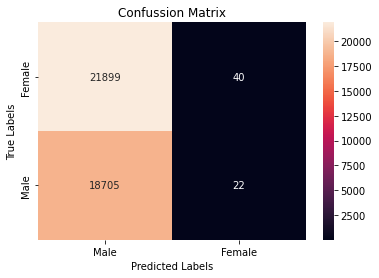

In [60]:
cm = confusion_matrix(labels, preds)
ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt='g', ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confussion Matrix")
ax.xaxis.set_ticklabels(['Male', 'Female']) 
ax.yaxis.set_ticklabels(['Female', 'Male'])

In [61]:
d1 = nlp
d2 = neigh

with open (r'..\data\models\genderModel\nlp.pkl', 'wb') as f1:
    pickle.dump(d1, f1)
with open (r'..\data\models\genderModel\neigh.pkl', 'wb') as f2:
    pickle.dump(d2, f2)

In [62]:
# load the model from disk
#txt = '"active", "adventurous", "aggress", "ambitio", "analy", "assert", "athlet", "autonom", "battle", "boast", "challeng", "champion", "compet", "confident", "courag", "decid", "decision", "decisive", "defend", "determin", "domina", "dominant", "driven", "fearless", "fight", "force", "greedy", "headstrong", "hierarch", "hostil", "impulsive", "independen", "individual", "intellect", "lead", "logic", "objective", "opinion", "outspoken", "persist", "principle", "reckless", "selfconfiden", "selfrelian", "selfsufficien", "stubborn", "superior", "unreasonab"'
txt = '"agree", "affectionate", "child", "cheer", "collab", "commit", "communal", "compassion", "connect", "considerate", "cooperat", "depend", "emotiona", "empath", "feel", "flatterable", "gentle", "honest", "interpersonal", "interdependen", "interpersona", "kind", "kinship", "loyal", "modesty", "nag", "nurtur", "pleasant", "polite", "quiet", "respon", "sensitiv", "submissive", "support", "sympath", "tender", "together", "trust", "understand", "warm", "whin", "enthusias", "inclusive", "yield", "share", "sharin"'

with open(r'..\data\models\genderModel\nlp.pkl', 'rb') as f1:
    nlp_load = pickle.load(f1)

with open(r'..\data\models\genderModel\neigh.pkl', 'rb') as f2:
    neigh_load = pickle.load(f2)

predict(txt, nlp_load, neigh_load)

1